<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Concept%20drift%EC%9D%98%20%ED%83%90%EC%A7%80%20%EB%B0%A9%EB%B2%95_1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift의 탐지 방법 <br>

concept drift detect method

# 1. Introduction

* Data Drift의 상황에서는 재학습 (retrain)을 하면 되지만, Concept Drift 상황에서는 p(y|x)의 상관관계가 변화되었으므로 새롭게 모델을 학습 즉, remodeling을 해야 한다.
* 하지만, on-line data에 대하여 Drift를 측정(ks-test 등)할 수 있어도, 이 상황이 Data Drift (or virtual concept drift)인지 진짜 Concept Drift인지를 파악하기 어렵다.
* 이런 상황에서 단순히 재학습을 하여 모델을 운영한다면, 역시 성능 회복이 안될 것이며, 이를 인지하지 못한 상태로 모델을 계속 운영할 수 있다.
* 이러한 운영상의 문제점을 극복하기 위해, Concept Drift를 탐지하고자 한다. 












# 2. 이론적 배경



# 3. Proposed Method

## pseudo code

# 4. 실험 계획

*   Data
1. Personal Loan Data
> 미국의 개인 대출 기업 ‘Lending Club’의 공개 데이터 사용<BR>
> 2007~2017년까지 총 2,260,701건의 데이터, 대출 건당 실제 ‘default’ 여부 포함
151개 Column<BR>
> 데이터 정제 후, 81개 Features, 120만건 사용<BR>
>> trainset : 11,497건 (2010년)<BR>
>> online dataset : 1,268,183건 (2011~2017년)<BR>



# 5. 실험을 위한 기본 준비 

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 4.9 MB/s 
     |████████████████████████████████| 5.3 MB 68.4 MB/s 
     |████████████████████████████████| 3.3 MB 45.0 MB/s 
     |████████████████████████████████| 34.5 MB 53.8 MB/s 
     |████████████████████████████████| 163 kB 55.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.9 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.3
    Uninstalling numba-0.56.3:
      Successfully uninstalled numba-0.56.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [4]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    

# 7. loan predict 실험

## 데이터 구축

In [5]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)


### 데이터 정제

In [6]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


In [7]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

In [8]:
# maybe we can go further, and eliminate columns up to title:

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [9]:
# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [10]:
# These are constant columns. We can drop it either.

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

In [11]:
# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

In [12]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])


In [13]:
df_accepted

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [14]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [15]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


In [16]:
df_accepted.shape

(1341026, 86)

In [17]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
df_accepted.shape

(1341026, 83)

In [18]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [19]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [20]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

In [21]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1341026 non-null  float64
 1   term                        1341026 non-null  int64  
 2   int_rate                    1341026 non-null  float64
 3   annual_inc                  1341026 non-null  float64
 4   issue_d                     1341026 non-null  object 
 5   dti                         1341026 non-null  float64
 6   delinq_2yrs                 1341026 non-null  float64
 7   fico_range_high             1341026 non-null  float64
 8   inq_last_6mths              1341026 non-null  float64
 9   open_acc                    1341026 non-null  float64
 10  pub_rec                     1341026 non-null  float64
 11  revol_bal                   1341026 non-null  float64
 12  revol_util                  1341026 non-null  float64
 1

In [22]:
df_accepted[['G1','G2','G3','G4']]

,G1,G2,G3,G4
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1341021,0,0,0,0
1341022,0,0,0,0
1341023,0,0,0,0
1341024,0,0,0,0


### dataset 만들기

In [23]:
X = {}
Y = {}

In [24]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [25]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [26]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [27]:
X[2010].shape

(11497, 81)

In [28]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns

In [29]:
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

## 예측 모델 구축

In [30]:
ML = {}
scaler = MinMaxScaler()

In [31]:
MODEL_TYPE = 'RF'  ## RF / DL

### random forest 모델

In [32]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [33]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(X_train,y_train)
    return model

### loan predict model build

In [34]:
seed_everything()

offset = int(Y[2010].shape[0] * 0.7)
y_ref = Y[2010][0:offset]
x_ref = X[2010][0:offset]
y_inf = Y[2010][offset:]
x_inf = X[2010][offset:]

ML[2010] = build_model_rf(year,x_ref,y_ref,epochs=5)

In [35]:
dd = np.zeros((4,4))
# add intercept term
intc = np.ones((dd.shape[0],1))
dd = np.concatenate((dd,intc),axis=1)
dd.shape

(4, 5)

In [36]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(y_inf, ML[2010].predict(scaler.transform(x_inf)),average='binary')
base_score

(0.9908045977011494, 1.0, 0.9953810623556583, None)

## loan predict model의 성능 예측 실험

In [37]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))

In [38]:
print("trainset:",X[2010].shape)
print("online dataset:",X2.shape)

trainset: (11497, 81)
online dataset: (1268183, 81)


### 실험

## shap에 의한 feature importance 분석

In [39]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

In [40]:
REFERENCE_YEAR = 2010

In [41]:
importances = ML[REFERENCE_YEAR].feature_importances_
imp_df1 = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

forest_importances = pd.Series(importances, index=COLUMNS)
monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:7])
print(monitoring_feature)

imp_df1.loc[len(imp_df1)] = importances

#forest_importances.to_dict()
#importances.reshape(-1,1)

imp_df1

['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term', 'Y']


,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,...,renewable_energy,small_business,vacation,wedding,MORTGAGE,OTHER,OWN,RENT,DirectPay,Y
0,0.004492,0.022712,0.023612,0.005847,0.002975,0.000752,0.010657,0.00359,0.002351,0.002788,...,0.000109,0.002169,0.000076,0.000146,0.000506,0.000122,0.000621,0.000196,0.0,0.018601
1,0.004492,0.022712,0.023612,0.005847,0.002975,0.000752,0.010657,0.00359,0.002351,0.002788,...,0.000109,0.002169,0.000076,0.000146,0.000506,0.000122,0.000621,0.000196,0.0,0.018601


In [69]:
def XAI(model,X_test,top=6):

    XAI_Explainer = None
    if MODEL_TYPE == 'DL':
        XAI_Explainer = shap.DeepExplainer
        xs = X_test[0:10]
        model(X_test)
    else:
        XAI_Explainer = shap.TreeExplainer
        xs = X_test[0:10]

    explainer = XAI_Explainer(model,X_test)
    
    shap_values = explainer.shap_values(xs)
    vals= np.abs(shap_values).mean(0)*2
    feature_importance = {}
    for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
        feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

    sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
    
    monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
    return feature_importance, monitoring_feature, shap_values

In [70]:
def get_feature_importance(model,X_test,display=False):
    #model = ML[year]
    X_test = scaler.transform(X_test)

    # ##### EXPLANATIONS #####
    #print()
    #print("Generating explanations...")
    
    df_x_test = pd.DataFrame(X_test,columns=COLUMNS)

    feature_importance, monitoring_feature, shap_values = XAI(model,X_test,top=5)
    #print('monitoring_feature',monitoring_feature)
    if display:
        plt.figure(figsize=(30,15))
        shap.summary_plot(shap_values, df_x_test, show=False, class_names=['Fully pad','charge-off'])
        plt.grid()
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')
        plt.show()
    return feature_importance, monitoring_feature,shap_values

In [44]:
X[REFERENCE_YEAR].shape

(11497, 81)

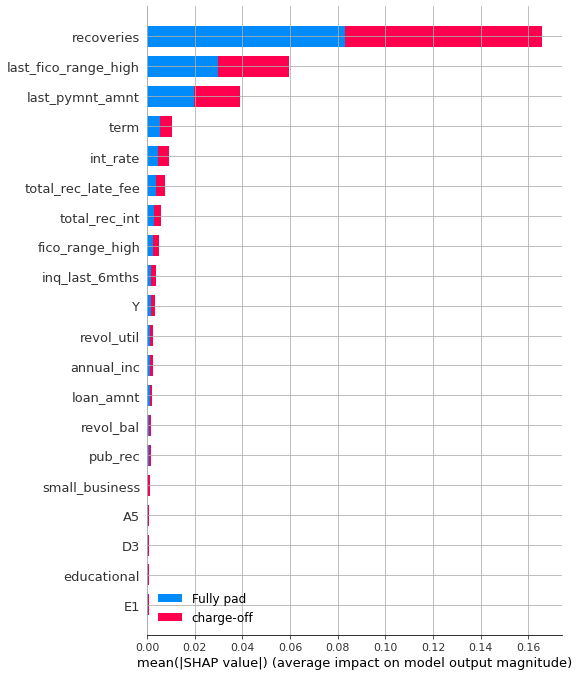

In [71]:
feature_importance, monitoring_feature, imp_values = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR],display=True)

In [86]:
np.asarray(list(feature_importance.values())).reshape(-1,)

array([2.06750117e-03, 1.24491200e-02, 1.55769648e-02, 3.83117378e-03,
       2.31402813e-03, 3.11762932e-04, 4.25203476e-03, 1.40569506e-03,
       1.90750674e-03, 7.78701384e-03, 1.16998748e-03, 1.34530684e-03,
       4.90714607e-04, 4.53151204e-03, 2.00648690e-03, 8.66581780e-02,
       3.16833782e-02, 3.78751967e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.96357407e-03, 0.00000000e+00,
       1.30550234e-04, 2.50567405e-04, 6.24732494e-05, 9.26673477e-04,
       2.64119776e-05, 0.00000000e+00, 7.44566649e-05, 2.31532729e-05,
       7.86640326e-05, 7.90488731e-05, 2.58002944e-05, 1.96230917e-04,
       5.29932021e-06, 7.81025457e-05, 1.85623720e-04, 7.85854409e-05,
       1.81746037e-04, 7.00784364e-06, 2.71970189e-04, 4.10045739e-04,
       0.00000000e+00, 5.11676773e-05, 4.99967095e-05, 0.00000000e+00,
       4.70659473e-05, 4.95036412e-05, 0.00000000e+00, 5.99111351e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [87]:
import math

batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
#df['f1_c'] = []

predict = ML[REFERENCE_YEAR].predict
importances = ML[REFERENCE_YEAR].feature_importances_
imp_df = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)
imp_df_pred = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

feature_importance, monitoring_feature, imp_values = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR],display=False)
imp_df_shap = pd.DataFrame(feature_importance)

for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    Y3_ = predict(scaler.transform(X3))
    f1 = precision_recall_fscore_support(Y3, Y3_ ,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['f1'].append(f1[2])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정
    model2 = RandomForestClassifier(n_estimators=80,max_depth=5)
    scaler2 = MinMaxScaler()
    model2.fit(scaler2.fit_transform(X3),Y3)
    imp_df.loc[len(imp_df)] = model2.feature_importances_

    model3 = RandomForestClassifier(n_estimators=80,max_depth=5)
    model3.fit(scaler2.fit_transform(X3),Y3_)
    imp_df_pred.loc[len(imp_df_pred)] = model3.feature_importances_

    feature_importance, monitoring_feature, imp_values = get_feature_importance(ML[REFERENCE_YEAR],X3,display=False)
    imp_df_shap.loc[len(imp_df_shap)] = np.asarray(list(feature_importance.values())).reshape(-1,)

    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)



df1 = pd.DataFrame(df)



127/127 f1:0.9305

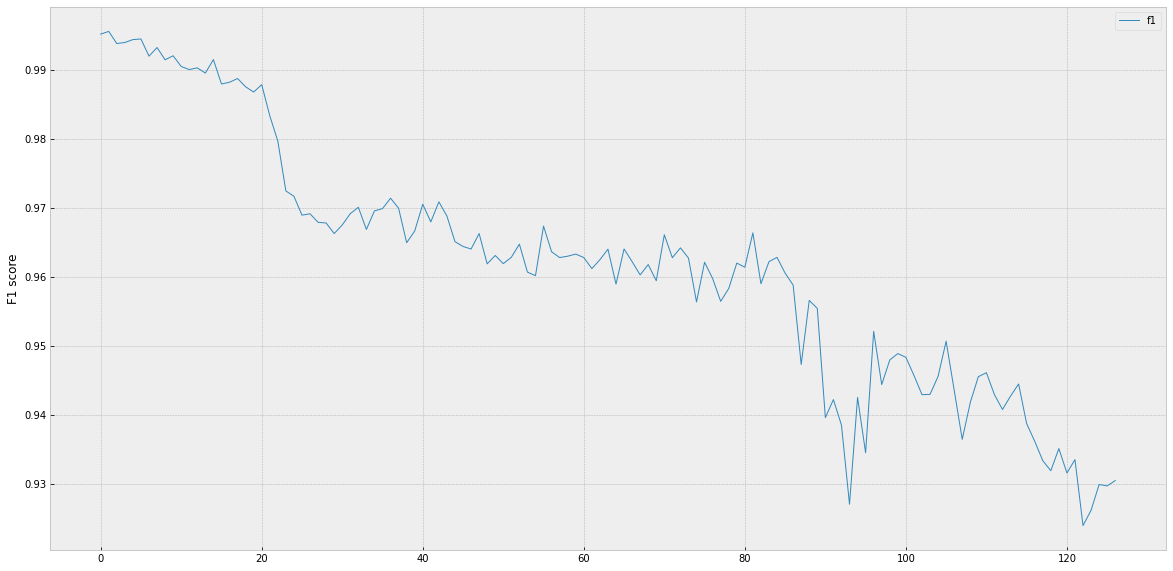

In [88]:
plt.style.use('bmh')
df1.plot(ylabel='F1 score',linewidth=1,figsize=(20,10))

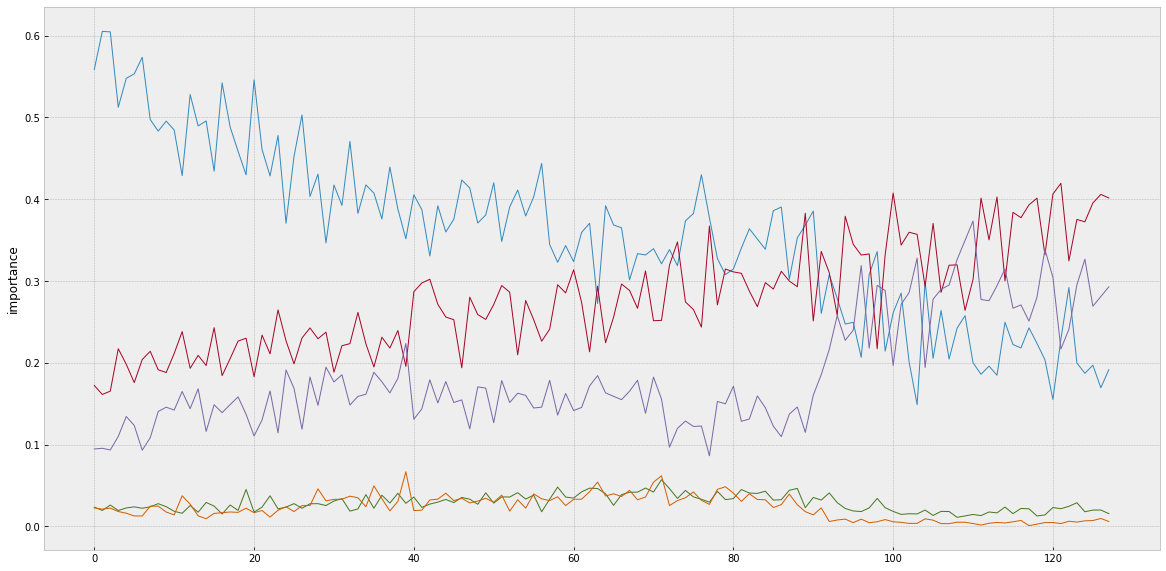

In [91]:
imp_df[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=False)

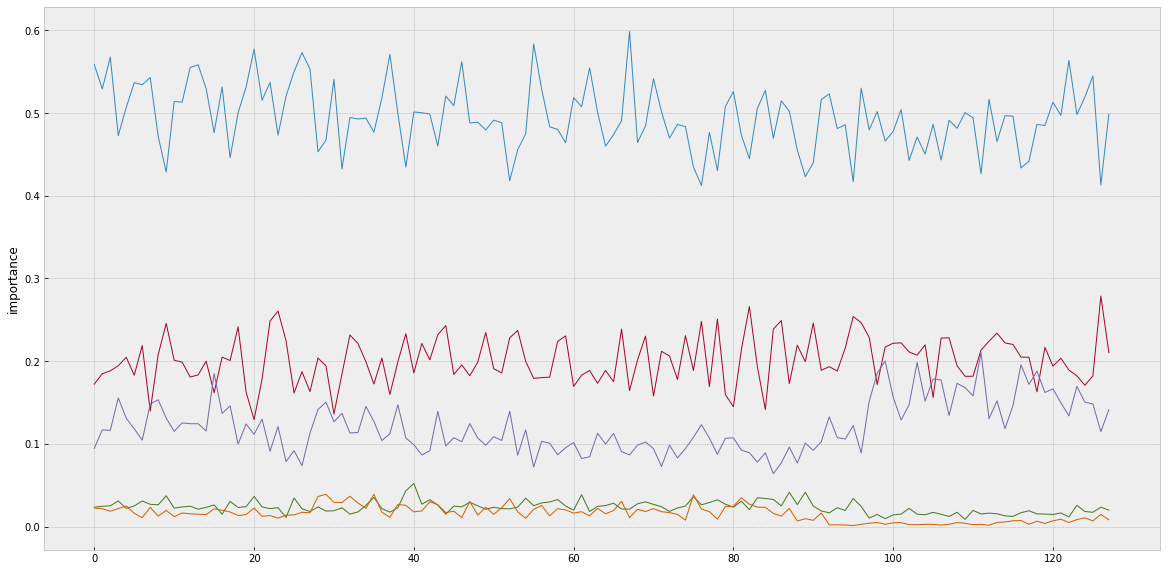

In [90]:
imp_df_pred[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=False)

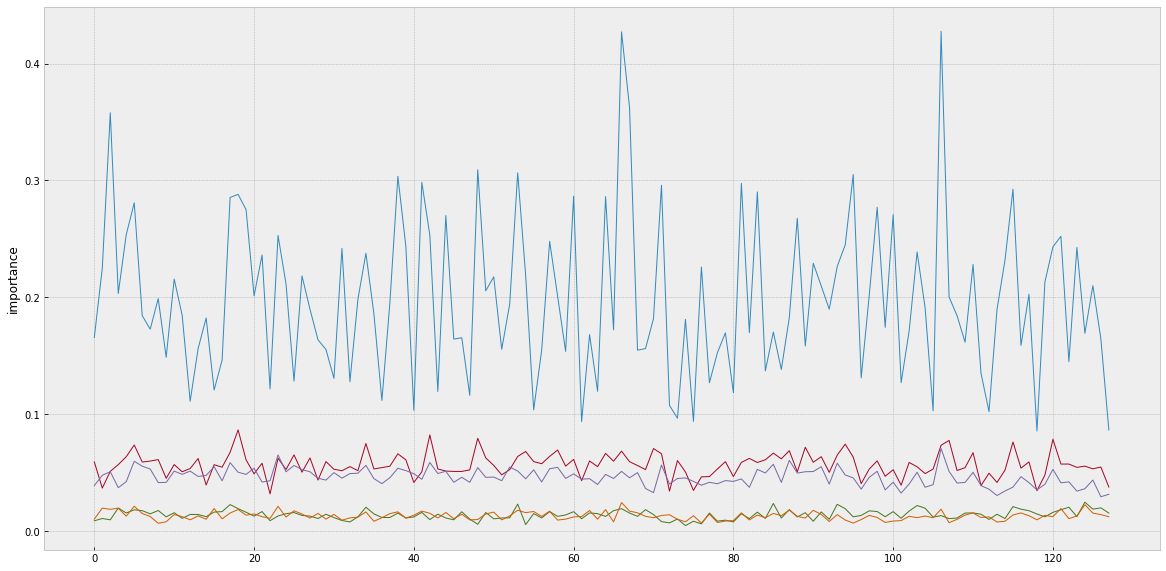

In [89]:
imp_df_shap[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=False)

In [92]:
imp_df_shap

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,...,renewable_energy,small_business,vacation,wedding,MORTGAGE,OTHER,OWN,RENT,DirectPay,Y
0,0.002105,0.010452,0.009003,0.002502,0.000693,0.000698,0.005164,0.003567,0.000397,0.001448,...,0.000032,0.001003,0.000056,0.000070,0.000150,0.0,0.000040,0.000147,0.0,0.003119
1,0.002028,0.019837,0.010978,0.000571,0.000603,0.000391,0.003683,0.003103,0.000869,0.000848,...,0.000000,0.001714,0.000000,0.000067,0.000179,0.0,0.000204,0.000325,0.0,0.000000
2,0.004544,0.018825,0.009840,0.002016,0.002103,0.000211,0.007745,0.002975,0.001405,0.000428,...,0.000000,0.002747,0.000004,0.000052,0.000270,0.0,0.000201,0.000157,0.0,0.000000
3,0.003825,0.019789,0.019927,0.000747,0.001800,0.000158,0.004772,0.001470,0.001090,0.002709,...,0.000000,0.004101,0.000000,0.000000,0.000289,0.0,0.000475,0.000162,0.0,0.003059
4,0.003654,0.012966,0.015677,0.002135,0.001249,0.000331,0.004979,0.005534,0.000178,0.000922,...,0.000000,0.001676,0.000079,0.000029,0.000137,0.0,0.000139,0.000054,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.003444,0.013128,0.012572,0.003247,0.002371,0.001569,0.001309,0.001790,0.000919,0.004384,...,0.000000,0.000000,0.000063,0.000000,0.000253,0.0,0.000815,0.000318,0.0,0.000000
124,0.006774,0.022725,0.024917,0.001218,0.002780,0.002721,0.003409,0.001486,0.002134,0.007350,...,0.000000,0.003796,0.000029,0.000000,0.000853,0.0,0.000969,0.000525,0.0,0.017390
125,0.003377,0.015578,0.019001,0.001504,0.002368,0.000586,0.004506,0.001565,0.000883,0.004747,...,0.000030,0.000000,0.000000,0.000000,0.000528,0.0,0.001428,0.000249,0.0,0.037276
126,0.005001,0.014303,0.020060,0.001563,0.001720,0.000238,0.005165,0.000869,0.000768,0.004883,...,0.000000,0.000000,0.000008,0.000000,0.000290,0.0,0.000667,0.000194,0.0,0.006254
